In [1]:
#Generate linear dataset.


def generate_linear(n=100):
    import numpy as np
    pts = np.random.uniform(0, 1, (n,2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0],pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)


#Generate fundamental XOR dataset.

def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1*i == 0.5:
            continue
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(21,1)

In [2]:
#Show result.

def show_result(x, y, pred_y):
    import matplotlib.pyplot as plt
    print("Show Result-----------------")
    #Ground truth chart
    plt.subplot(1,2,1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    
    #Predicted chart
    plt.subplot(1,2,2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.show()

def print_acc(y ,pred_y ):
    import numpy as np
    correct = np.where(y == pred_y ,1 ,0 )
    print("Accuaracy=" , np.count_nonzero(correct)/len(correct))
    
def print_learning_curve(epoch, loss):
    import matplotlib.pyplot as plt
    print("Show Learning Curve-----------")
    plt.plot(range(1,epoch+1), loss,'b' ,label = "Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [3]:
#Generate model

class NeuralNetwork:
    
    def add_tensor(self, *n):
        import numpy as np
        np.random.seed(65536)
        tensor = np.random.uniform(-1, 1,(n));
        return tensor
    
    def convolution(self,x,h):
        import numpy as np        
        padding = np.zeros((1,len(x[0])))
        padding_matrix = np.concatenate((padding ,x ), axis = 0)
        padding_matrix = np.concatenate((padding_matrix ,padding ), axis = 0)        
        output = np.zeros((len(padding_matrix)-len(h)+1,len(padding_matrix[0]) - len(h[0]) + 1))
        for i in range(len(output)):
            for j in range(len(output[0])):
                output[i][j] = (padding_matrix[i: i+len(h), j: j+len(h[0])] * h).sum()
        return output
    
    def fully_convolution(self,dy,h):
        import numpy as np
        output = np.zeros((len(dy),len(h[0])))
        output[0] = h[0,:]*dy[1,0]+h[1,:]*dy[0,0]
        output[99] = h[2,:]*dy[98,0]+h[1,:]*dy[99,0]
        for i in range(1,99):
            output[i] = h[0,:]*dy[i+1,0]+h[1,:]*dy[i,0]+h[2,:]*dy[i-1,0]
        #output += np.dot(dy,h[1].reshape(1,len(h[1])))
        #output[0:-1] += np.dot(dy,h[0].reshape(1,len(h[0])))[1:,0]
        #output[1:] += np.dot(dy,h[2].reshape(1,len(h[2])))[:-1,0]
        return output
    
    def feed_forward(self,x):
        import numpy as np
        if  self.hidden_layer_name[0] == "Dot":
            self.hidden_layer_output[0] = np.dot(x,self.hidden_layer[0])
        if self.activate_func[0] == 'sigmoid':
            self.activate_func_output[0] = self.sigmoid(self.hidden_layer_output[0])
        if self.activate_func[0] == 'relu':
            self.activate_func_output[0] = self.relu(self.hidden_layer_output[0])
        if self.activate_func[0] == 'none' :
            self.activate_func_output[0] = self.hidden_layer_output[0]
        if  self.hidden_layer_name[1] == "Dot":
            self.hidden_layer_output[1] = np.dot(self.activate_func_output[0],self.hidden_layer[1])
        if  self.hidden_layer_name[1] == "Convolutional": 
            self.hidden_layer_output[1] = self.convolution(self.activate_func_output[0],self.hidden_layer[1])
        if self.activate_func[1] == 'sigmoid':
            self.activate_func_output[1] = self.sigmoid(self.hidden_layer_output[1])
        if self.activate_func[1] == 'relu':
            self.activate_func_output[1] = self.relu(self.hidden_layer_output[1])
        if self.activate_func[1] == 'none' :
            self.activate_func_output[1] = self.hidden_layer_output[1]    
        return self.activate_func_output[1]
        
    def sigmoid(self,x):
        import numpy as np
        return 1.0/(1.0 + np.exp(-x))
    
    def derivative_sigmoid(self,z,x):
        import numpy as np
        return z * (1.0-z) * x
    
    def relu(self,x):
        import numpy as np
        return np.where(x>0 ,x ,0 )
    
    def derivative_relu(self,z,x):
        import numpy as np        
        return np.where(z>0 ,x ,0 )
    
    def binary_cross_entropy(self,y,pred_y):
        import numpy as np
        pred_y=np.where(pred_y==1 ,0.999999999, pred_y)
        pred_y=np.where(pred_y==0 ,0.000000001, pred_y)
        return -1.0*(np.dot(y.reshape(len(y)),np.log(pred_y.reshape(len(y))))+np.dot((1.0-y.reshape(len(y))),np.log(1.0-pred_y.reshape(len(y)))))/len(y)
    
    def derivative_binary_cross_entropy(self,y,pred_y):
        import numpy as np
        pred_y=np.where(pred_y==1 ,0.999999999, pred_y)
        pred_y=np.where(pred_y==0 ,0.000000001, pred_y)
        return (pred_y-y)/(pred_y*(1-pred_y))
    
    def back_propogation(self,x,y,pred_y,t,learning_rate):
    #Calculate derivative.
        import numpy as np
        #derivative of binary cross entropy
        self.activate_func_output_gradiant[1] = self.derivative_binary_cross_entropy(y,pred_y)
        #derivative of activation function
        if self.activate_func[1] == 'sigmoid' :
            self.hidden_layer_output_gradiant[1] = self.derivative_sigmoid(self.activate_func_output[1],self.activate_func_output_gradiant[1])
        if self.activate_func[1] == 'relu' :
            self.hidden_layer_output_gradiant[1] = self.derivative_relu(self.activate_func_output[1],self.activate_func_output_gradiant[1])
        if self.activate_func[1] == 'none' :
             self.hidden_layer_output_gradiant[1] = self.activate_func_output_gradiant[1]
        #derivative of dot
        #if dot(X,W)=Y
        #dY/dW = dot(X^T,previous_chained_rule)
        if  self.hidden_layer_name[1] == "Dot": 
            self.hidden_layer_gradiant[1] = np.dot(np.transpose(self.activate_func_output[0]),self.hidden_layer_output_gradiant[1])
        #derivative of convolution
        if  self.hidden_layer_name[1] == "Convolutional": 
            self.hidden_layer_gradiant[1] = self.convolution(self.activate_func_output[0],self.hidden_layer_output_gradiant[1])
            
        #derivative of dot
        #if dot(X,W)=Y
        #dY/dX = dot(previous_chained_rule,W^T)
        if  self.hidden_layer_name[1] == "Dot": 
            self.activate_func_output_gradiant[0] = np.dot(self.hidden_layer_output_gradiant[1],np.transpose(self.hidden_layer[1]))
        #derivative of convolution
        #if X conv W=Y
        # dy/dw= X conv previous_chained_rule
        if  self.hidden_layer_name[1] == "Convolutional":
            self.activate_func_output_gradiant[0] = self.fully_convolution(self.hidden_layer_output_gradiant[1],self.hidden_layer[1])
        #derivative of activation function
        if self.activate_func[0] == 'sigmoid':
            self.hidden_layer_output_gradiant[0] = self.derivative_sigmoid(self.activate_func_output[0],self.activate_func_output_gradiant[0])
        if self.activate_func[0] == 'relu' :
            self.hidden_layer_output_gradiant[0] = self.derivative_relu(self.activate_func_output[0],self.activate_func_output_gradiant[0])
        if self.activate_func[0] == 'none' :
            self.hidden_layer_output_gradiant[0] = self.activate_func_output_gradiant[0]
        #derivative of dot
        #if dot(X,W)=Y
        #dY/dW = dot(X^T,previous_chained_rule)
        self.hidden_layer_gradiant[0] = np.dot(np.transpose(x),self.hidden_layer_output_gradiant[0])


    #Optimizate the parameter.
        if self.optimizer == "momentum":
            self.layer1_v = self.a * self.layer1_v - learning_rate * self.hidden_layer_gradiant[0]
            self.hidden_layer[0] += self.layer1_v
            self.layer2_v = self.a * self.layer2_v - learning_rate * self.hidden_layer_gradiant[1]
            self.hidden_layer[1] += self.layer2_v            

        if self.optimizer == "BGD":
            self.hidden_layer[0] -= learning_rate * self.hidden_layer_gradiant[0]        
            self.hidden_layer[1] -= learning_rate * self.hidden_layer_gradiant[1]
        
    def train(self,data_name,x,y,epoch=10000,learning_rate=0.0005,print_epoch=5000):
        import numpy as np
        print("Training Mode-------------------------")
        print("Data: ", data_name)
        print("Optimizer: ", self.optimizer)
        print("Learning rate: ", learning_rate)
        if self.optimizer == "momentum":
            print("parameter_m: ", self.a)
        print("Total epochs: ", epoch) 
        loss_list = []
        for i in range(epoch):
            pred_y = self.feed_forward(x)
            self.back_propogation(x,y,pred_y,(i+1),learning_rate)
            loss = self.binary_cross_entropy(y,pred_y)
            loss_list.append(loss)
            if ((i+1)%print_epoch) == 0 :
                print("epoch=", i+1,"    loss=",loss)
        print_learning_curve(epoch,np.array(loss_list))
            
    def prediction(self,x):
        print("Testing Mode-------------------------")
        pred_y = self.feed_forward(x)
        return pred_y
    
    #init
    def __init__(self, model_name, input, size, first_activate_func="sigmoid",optimizer="BGD",second_hidden_layer="Dot"):
        ##layer
        self.hidden_layer_name=[]
        self.hidden_layer=[]
        self.hidden_layer_gradiant=[]
        self.hidden_layer_output=[]
        self.hidden_layer_output_gradiant=[]
        if(first_activate_func=="sigmoid"):
            self.activate_func=['sigmoid','sigmoid']
        if(first_activate_func=="relu"):
            self.activate_func=['relu','sigmoid']
        if(first_activate_func=="none"):
            self.activate_func=['none','sigmoid']
        self.activate_func_output=[]
        self.activate_func_output_gradiant=[]        
        self.size = size
        
        self.hidden_layer_name.append("Dot")
        self.hidden_layer.append(self.add_tensor(2,self.size))
        self.hidden_layer_gradiant.append(self.add_tensor(2,self.size))
        self.hidden_layer_output.append(self.add_tensor(input,self.size))
        self.hidden_layer_output_gradiant.append(self.add_tensor(input,self.size))
        self.activate_func_output.append(self.add_tensor(input,self.size))
        self.activate_func_output_gradiant.append(self.add_tensor(input,self.size))
        
        self.hidden_layer_name.append(second_hidden_layer)
        
        if second_hidden_layer == "Dot":
            self.hidden_layer.append(self.add_tensor(self.size,1))
            self.hidden_layer_gradiant.append(self.add_tensor(self.size,1))
            self.hidden_layer_output.append(self.add_tensor(input,1))
            self.hidden_layer_output_gradiant.append(self.add_tensor(input,1))
            
        if second_hidden_layer == "Convolutional":
            self.hidden_layer.append(self.add_tensor(3,self.size))
            self.hidden_layer_gradiant.append(self.add_tensor(3,self.size))
            self.hidden_layer_output.append(self.add_tensor(input,1))
            self.hidden_layer_output_gradiant.append(self.add_tensor(input,1))   
            
        self.activate_func_output.append(self.add_tensor(input,1))
        self.activate_func_output_gradiant.append(self.add_tensor(input,1))
        ##optimizer
        self.optimizer = optimizer
        if self.optimizer == "momentum":
            self.a = 0.99
            if second_hidden_layer == "Dot":
                self.layer1_v = np.zeros((2,self.size))  
                self.layer2_v = np.zeros((self.size,1))
            if second_hidden_layer == "Convolutional":
                self.layer1_v = np.zeros((2,self.size))  
                self.layer2_v = np.zeros((3,self.size))
        ##print init_model information
        print("Initialize Model----------")
        print("Model Name: ", model_name)
        print("First layer: ",self.hidden_layer_name[0] ," layer ", "Size = ", "(", 2, ",", self.size, ")")
        print("First activation function: ", self.activate_func[0])
        if self.hidden_layer_name[1] == "Dot":
            print("Second layer: ",self.hidden_layer_name[1] ," layer ", "Size = ", "(", self.size, ",", 1, ")")
        if self.hidden_layer_name[1] == "Convolutional":
            print("Second layer: ",self.hidden_layer_name[1] ," layer ", "Size = ", "(", 3, ",",  self.size,")")
        print("Second activation function: ", self.activate_func[1])

Initialize Model----------
Model Name:  Model1
First layer:  Dot  layer  Size =  ( 2 , 1000 )
First activation function:  relu
Second layer:  Convolutional  layer  Size =  ( 3 , 1000 )
Second activation function:  sigmoid
Training Mode-------------------------
Data:  Linear
Optimizer:  momentum
Learning rate:  1e-06
parameter_m:  0.99
Total epochs:  10000
epoch= 1000     loss= 5.001595913834558
epoch= 2000     loss= 1.5184358537636322
epoch= 3000     loss= 0.4227150493391772
epoch= 4000     loss= 0.047650128669920376
epoch= 5000     loss= 0.019847245692804858
epoch= 6000     loss= 0.013475988366834446
epoch= 7000     loss= 0.0102244657751423
epoch= 8000     loss= 0.008215074905624849
epoch= 9000     loss= 0.00685362911620078
epoch= 10000     loss= 0.005872044167633058
Show Learning Curve-----------


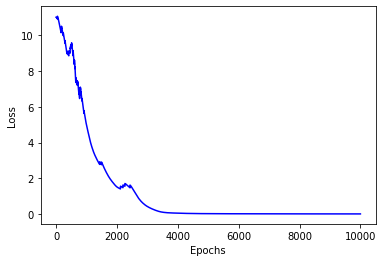

Testing Mode-------------------------
Prediction: [[2.79042066e-67]
 [3.92090359e-05]
 [2.89977547e-39]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.32964922e-14]
 [9.95201247e-01]
 [5.81174421e-16]
 [1.00000000e+00]
 [8.38644621e-13]
 [5.60862444e-07]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.84444235e-19]
 [4.65920793e-13]
 [1.00000000e+00]
 [2.42129871e-13]
 [1.00000000e+00]
 [1.00000000e+00]
 [6.76991330e-07]
 [9.99997677e-01]
 [1.33214115e-21]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.86810388e-49]
 [1.50319578e-52]
 [1.00000000e+00]
 [9.99999999e-01]
 [5.87910858e-37]
 [5.78029900e-25]
 [1.00000000e+00]
 [6.28186239e-60]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.96782436e-01]
 [9.99999871e-01]
 [7.59235293e-20]
 [1.97687882e-27]
 [9.99999535e-01]
 [1.70506508e-50]
 [9.19711816e-57]
 [1.62473708e-07]
 [8.51146982e-12]
 [1.00000000e+00]
 [8.83111006e-01]
 [1.87547649e-58]
 [1.51020125e-04]
 [1.00000000e+00]
 [1.45356500e-13]
 [2.74127343e-09]
 [1.00000000e+00]
 [1.00000000e+

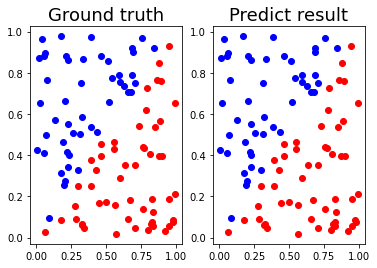

Accuaracy= 1.0
Initialize Model----------
Model Name:  Model2
First layer:  Dot  layer  Size =  ( 2 , 500 )
First activation function:  sigmoid
Second layer:  Dot  layer  Size =  ( 500 , 1 )
Second activation function:  sigmoid
Training Mode-------------------------
Data:  XOR_easy
Optimizer:  BGD
Learning rate:  0.001
Total epochs:  150000
epoch= 10000     loss= 0.684975430301347
epoch= 20000     loss= 0.6533131527074912
epoch= 30000     loss= 0.5368145744755504
epoch= 40000     loss= 0.4465690919101418
epoch= 50000     loss= 0.3943145092840465
epoch= 60000     loss= 0.34547056500847007
epoch= 70000     loss= 0.2817185300664744
epoch= 80000     loss= 0.22082169437529012
epoch= 90000     loss= 0.17836194703826552
epoch= 100000     loss= 0.14883218761232722
epoch= 110000     loss= 0.1267317005867824
epoch= 120000     loss= 0.1090196846561073
epoch= 130000     loss= 0.09410870999343901
epoch= 140000     loss= 0.0812057500705684
epoch= 150000     loss= 0.06993795620677412
Show Learning Cu

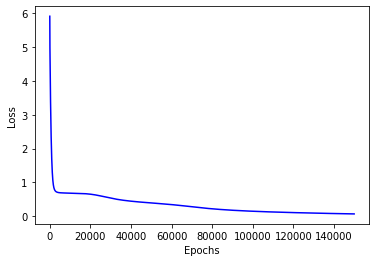

Testing Mode-------------------------
Prediction: [[3.22702792e-07]
 [9.95656404e-01]
 [5.56469134e-05]
 [9.96802835e-01]
 [3.76386242e-03]
 [9.96282116e-01]
 [5.71689547e-02]
 [9.88166786e-01]
 [1.85729807e-01]
 [7.40936709e-01]
 [2.12129523e-01]
 [1.25540938e-01]
 [6.50383733e-01]
 [4.50678208e-02]
 [9.86988852e-01]
 [1.18166500e-02]
 [9.99674559e-01]
 [2.69256547e-03]
 [9.99985649e-01]
 [5.92887208e-04]
 [9.99998885e-01]]
Show Result-----------------


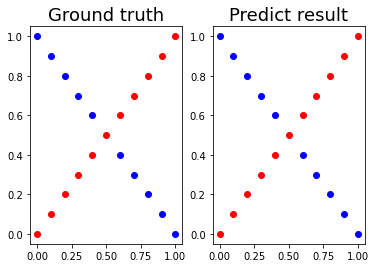

Accuaracy= 1.0


In [4]:
if __name__ == '__main__':
    import numpy as np
    x1, y1 = generate_linear(n=100)
    nn1=NeuralNetwork("Model1",100,1000,"relu","momentum","Convolutional")
    nn1.train("Linear",x1,y1,10000,0.000001,1000)
    pred_y1 = nn1.prediction(x1)
    print("Prediction:",pred_y1)
    show_result(x1,y1,np.where(pred_y1>=0.5,1,0))
    print_acc(y1,np.where(pred_y1>=0.5,1,0))
    
    x2, y2 = generate_XOR_easy()
    nn2=NeuralNetwork("Model2",21,500,"sigmoid","BGD","Dot")
    nn2.train("XOR_easy",x2,y2,150000,0.001,10000)
    pred_y2 = nn2.prediction(x2)
    print("Prediction:",pred_y2)
    show_result(x2,y2,np.where(pred_y2>=0.5,1,0))
    print_acc(y2,np.where(pred_y2>=0.5,1,0))